This notebook will calculate new crashes based only on existing crashes, so it is consistent with whatever type/source of existing crash data the tool uses, and is not dependent on the current implementation of the crashes model

This is the equation being implemented:
$NC_{cmojk}=EC_{cmoj} * (1 + \sum_{i}\sum_{F}E_{ik} * \frac{Ni}{L} * I_{F})^{p}*CRF_{mojk}$

In [1]:
import numpy as np
import pandas as pd

In [2]:
existing_crashes = pd.read_csv('output_2023_09_05/reports/safety-4-combined-b-crashes-all.csv')
infrastructure = pd.read_csv('output_2023_09_05/reports/overall-4-infrastructure-safety.csv')
infrastructure_volume_changes = pd.read_csv('output_2023_09_05/lookups/per_element_travel_adjustments.csv')

,Project ID,M Mode,O Outcome,J Location,User inputted crashes UImoj,ECmoj with user input,ECmoj split,ECmoj model,K estimate,CRFmojk,NCmojk
0,648253949d68d91158e2ea55,bicycling,crash,intersection,14.0,2.8,25.2,15.524892,lower,1.000000,17.077381
1,648253949d68d91158e2ea55,bicycling,crash,intersection,14.0,2.8,25.2,15.524892,mean,1.000000,21.734848
2,648253949d68d91158e2ea55,bicycling,crash,intersection,14.0,2.8,25.2,15.524892,upper,1.000000,25.557197
3,648253949d68d91158e2ea55,bicycling,crash,roadway,2.0,0.4,3.6,0.240298,lower,0.695556,0.183854
4,648253949d68d91158e2ea55,bicycling,crash,roadway,2.0,0.4,3.6,0.240298,mean,0.397778,0.133819
...,...,...,...,...,...,...,...,...,...,...,...
10039,64e4faa1cb0d64389a5ea129,combined,death,intersection,NaN,NaN,NaN,1.074715,mean,0.982491,1.085667
10040,64e4faa1cb0d64389a5ea129,combined,death,intersection,NaN,NaN,NaN,1.074715,upper,0.954476,1.075337
10041,64e4faa1cb0d64389a5ea129,combined,death,roadway,NaN,NaN,NaN,0.095171,lower,0.643056,0.061621
10042,64e4faa1cb0d64389a5ea129,combined,death,roadway,NaN,NaN,NaN,0.095171,mean,0.300278,0.029301


In [3]:
## Pull out the required variables: element, crashes volume increase per element, element share, improvement type, CRF
CRFmojk = existing_crashes["CRFmojk"]
element = infrastructure["Infrastructure type"]
element = "conventional-bike-lane"
share = infrastructure["Project share"]
## Fix later

In [4]:
## testing
volume_change = infrastructure_volume_changes[infrastructure_volume_changes["element"] == element]
volume_change.reset_index().at[0,"mean adjustment (%)"]

124

In [74]:
## Define the function
## have to iterate through all infrastructure for the one project ID
def new_NC(Project_ID, Estimate, EC, CRF):
    project_elements = infrastructure[infrastructure["Project ID"] == Project_ID]
    ##print(project_elements)
    volume_change_factor = 1
    for index, element in project_elements.iterrows():
        element_name = element["Infrastructure type"]
        ##print(element_name)
        share = element["Project share"]
        ##print("share is %s"% share)
        improvement_type = element["Improvement type"]
        ##print("improvement type is %s"% improvement_type)
        if improvement_type == "retrofit":
            improvement_factor = 0.1
        else:
            improvement_factor = 1
        ##if element_name in infrastructure_volume_changes["element"]:
        sel_volume_change = infrastructure_volume_changes[infrastructure_volume_changes["element"] == element_name]
        ##print("the length of sel_volume_change is: %s"% len(sel_volume_change))
        if len(sel_volume_change) == 0:
            volume_change = 0
            ##print("no sel_volume")
        else:
            ##print("sel_volume_change is %s"% sel_volume_change)
            volume_change = (sel_volume_change.reset_index().at[0, Estimate + " adjustment (%)"])/100
            ##print("volume_change")
        volume_change_factor += volume_change * share * improvement_factor
        ##print("volume_change_factor is %s"% volume_change_factor)
    ## volume change factor raised to "safety in numbers" power
    volume_change_factor = (volume_change_factor)**0.5
    NC = EC * volume_change_factor * CRF
    return NC
## I know this is not going to work because pandas iterates over columns, not rows, but just sketching out an idea
## Terrible and messy code
## Fix later - this is not the final implementation for the tool anyway, just testing to see if the equation improves the results

In [78]:
def apply_new_NC(element):
    Project_ID = element["Project ID"]
    EC = element["ECmoj model"]
    Estimate = element["K estimate"]
    CRF = element["CRFmojk"]
    NC = new_NC(Project_ID,Estimate,EC,CRF)
    return(NC)

In [79]:
for index, row in existing_crashes.iterrows():
    existing_crashes.at[index,"new_NC"] = apply_new_NC(row)
## existing_crashes.apply(apply_new_NC, 'columns', 'expand')

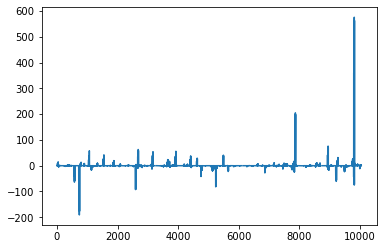

In [99]:
## Validate that these are equal?
(existing_crashes["new_NC"]-existing_crashes["NCmojk"]).plot()
## some weird stuff going on here
## Maybe errors with how one or the other was calculated

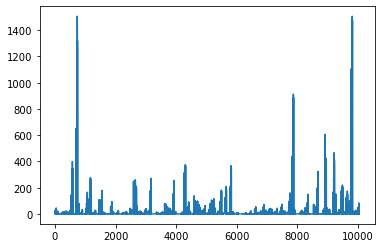

In [100]:
existing_crashes["new_NC"].plot()

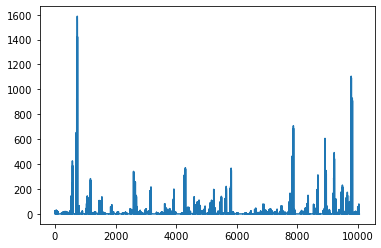

In [101]:
existing_crashes["NCmojk"].plot()

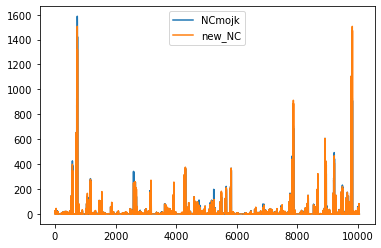

In [102]:
existing_crashes.plot(y=["NCmojk","new_NC"])